# K-means classification

In [1]:
%pylab inline
from matplotlib.pyplot import style
import matplotlib.pyplot as plt
# custom plots from minibrain
style.use('https://raw.githubusercontent.com/JoseGuzman/minibrain/master/minibrain/paper.mplstyle')

import pandas as pd

Populating the interactive namespace from numpy and matplotlib


# Load data

In [2]:
mydata = pd.read_csv('./DataSets/cell_data.csv')
print(f'{mydata.shape[0]} observations')
mydata.head()

165 observations


,diameter,Vmb
0,19.9340,NaN
1,20.8943,-27.6512
2,16.9050,NaN
3,NaN,NaN
4,18.9130,NaN


In [3]:
from scipy.stats import lognorm

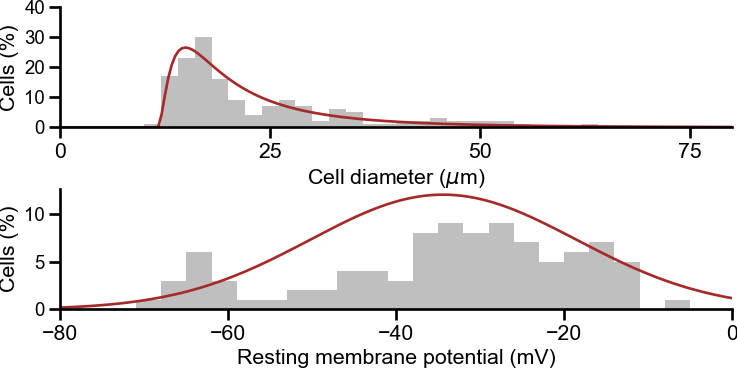

In [4]:
fig, ax = plt.subplots(2,1, figsize=(8,4))
fig.tight_layout()


# FIGURE 1: diameters
# remove NaN
diameters = np.ma.array(mydata.diameter.values, mask = np.isnan(mydata.diameter.values)).compressed()

# Obtain parameters for fitting with approximations to mean and standard deviation
params = lognorm.fit(diameters, loc = np.mean(diameters), scale = np.std(diameters))

xfit = np.linspace(0,80, 200)
mynorm = lognorm.pdf(xfit, *params)

mybins = np.arange(0,80,2)
mycounts = ax[0].hist(mydata.diameter, mybins, facecolor='gray', histtype='stepfilled', alpha=.5)
bincenter = [0.5 * (mybins[i] + mybins[i+1]) for i in range(len(mybins) -1 )]
binwidth = (max(bincenter) - min(bincenter)) / len(bincenter)

ax[0].plot(xfit, mynorm*binwidth*len(mydata.diameter), color='brown')

ax[0].set_xlim(left=0, right = 80)
ax[0].set_xticks(np.arange(0,100,25));
ax[0].set_ylabel('Cells (%)');
ax[0].set_xlabel('Cell diameter ($\mu$m)')
ax[0].set_yticks(np.arange(0,42,10));

# FIGURE 2: Vrest
vrest = np.ma.array(mydata.Vmb.values, mask = np.isnan(mydata.Vmb.values)).compressed()

# Obtain parameters for fitting with approximations to mean and standard deviation
params = lognorm.fit(vrest, loc = np.mean(vrest), scale = np.std(vrest))

xfit = np.linspace(-80,10, 200)
mynorm = lognorm.pdf(xfit, *params)

mybins = np.arange(-80,10,3)
mycounts = ax[1].hist(mydata.Vmb, mybins, facecolor='gray', histtype='stepfilled', alpha=.5)
bincenter = [0.5 * (mybins[i] + mybins[i+1]) for i in range(len(mybins) -1 )]
binwidth = (max(bincenter) - min(bincenter)) / len(bincenter)

ax[1].plot(xfit, mynorm*binwidth*len(mydata.diameter), color='brown')
ax[1].set_xlim(left=-80, right = 0)
ax[1].set_xticks(np.arange(-80,10,20))
ax[1].set_ylabel('Cells (%)');
ax[1].set_xlabel('Resting membrane potential (mV)');


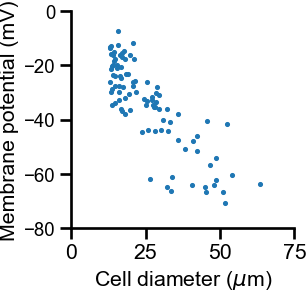

In [5]:
mymaks = np.isnan(mydata.Vmb.values)
y = np.ma.array(mydata.Vmb.values, mask = mymaks).compressed()
x = np.ma.array(mydata.diameter.values, mask = mymaks).compressed()
len(x) == len(y)
mydf = pd.DataFrame({'Vrest':y, 'diameter':x})

plt.figure(figsize(3,3))
plt.scatter(x,y, s=8)
plt.xlabel("Cell diameter ($\mu$m)"), plt.ylabel('Membrane potential (mV)')
plt.yticks(np.arange(-80,10,20));
plt.xticks(np.arange(0,100,25));

In [6]:
mydf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95 entries, 0 to 94
Data columns (total 2 columns):
Vrest       95 non-null float64
diameter    95 non-null float64
dtypes: float64(2)
memory usage: 1.6 KB


# Cluster with two centroids 

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [8]:
myscaler = StandardScaler()
z_score = myscaler.fit_transform(mydf)

In [9]:
myscaler.mean_, myscaler.scale_

(array([-34.29449021,  25.67656951]), array([15.82171801, 12.06188709]))

In [10]:
cfs = KMeans(n_clusters=2).fit(z_score)

In [11]:
mydf['kgroup'] = cfs.labels_

In [12]:
from scipy.spatial.distance import cdist

def plot_radii(mykmeans, X, ax = None):
    """
    Plots k-centroids from a kmeans model
    
    Arguments
    ---------
    mykmeans (Kmeans object)
        (sklearn.sklearn.cluster.Kmeans model)
    
    X (2D-Numpy array)
        The observations ith the observations)
    
    ax (an axis object)
    """
    # plot the input data
    ax = ax or plt.gca()
    
    labels = mykmeans.labels_ # read labels

    centers = myscaler.inverse_transform(mykmeans.cluster_centers_) # centroids corrected for normalization!
    
    radii = [cdist(X[labels == i], [center]).max() for i, center in enumerate(centers)]
    
    for c, r in zip(centers, radii):
        center = c[::-1]
        mycircle = plt.Circle(center, r, color='C0', lw=2, alpha=0.5, zorder=1, fill=False)
        ax.add_patch(mycircle)

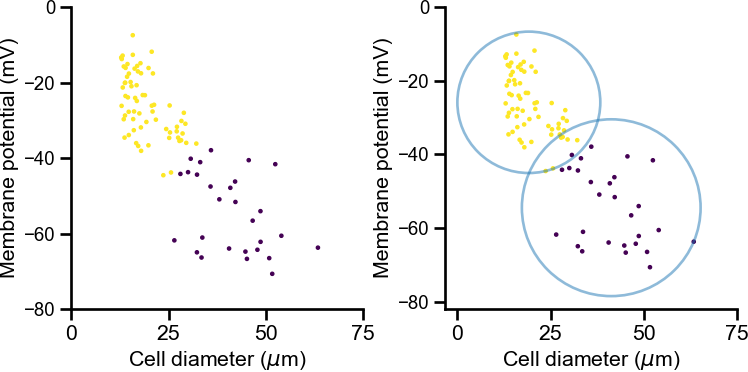

In [13]:
fig, ax = plt.subplots(1,2, figsize = (8,4))
fig.tight_layout()

ax[0].scatter(mydf.diameter, mydf.Vrest, c = mydf.kgroup, s = 6)

plot_radii(mykmeans = cfs, X = mydf.values[:,0:2], ax=ax[1])
ax[1].scatter(mydf.diameter, mydf.Vrest, c = mydf.kgroup, s = 6)

for myax in ax:
    myax.set_xlabel("Cell diameter ($\mu$m)");
    myax.set_ylabel('Membrane potential (mV)');
    myax.set_yticks(np.arange(-80,10,20));
    myax.set_xticks(np.arange(0,100,25));

In [14]:
mydf.head()

,Vrest,diameter,kgroup
0,-27.6512,20.89430,1
1,-24.8687,16.85182,1
2,-38.0629,17.95220,1
3,-12.6591,15.81813,1
4,-36.0233,16.68500,1


In [15]:
mydf.to_csv('./DataSets/Kmeans_classification.csv')

In [16]:
mydf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95 entries, 0 to 94
Data columns (total 3 columns):
Vrest       95 non-null float64
diameter    95 non-null float64
kgroup      95 non-null int32
dtypes: float64(2), int32(1)
memory usage: 2.0 KB


# Calculate inertias

In [17]:
inertia = list()
for k in range(2,20):
    clf = KMeans(n_clusters = k, init = 'k-means++').fit(z_score)
    inertia.append( clf.inertia_)

    

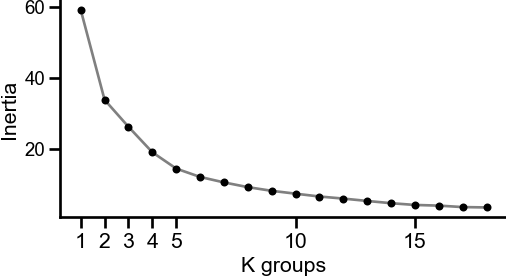

In [18]:
idx = np.arange(1, len(inertia)+1)
plt.figure(figsize=(6,3))
plt.plot(idx, inertia, '-', color='gray')
plt.plot(idx, inertia, 'ko', ms = 6)
plt.ylabel("Inertia"), plt.xlabel('K groups')
plt.xticks([1,2,3,4,5, 10, 15]);

Number of optimal k-clusters: 2


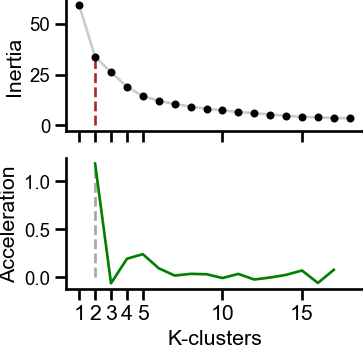

In [19]:
idx = np.arange(1, len(inertia) + 1)

fig, ax = plt.subplots(2, 1, figsize=(4,4), sharex=True)

ax[0].plot(idx, inertia, '-', color='gray', alpha = 0.4)
ax[0].plot(idx, inertia, 'ko', ms=6)
ax[0].set_xticks([1,2,3,4,5, 10, 15])

ax[0].set_ylabel('Inertia');

acceleration = np.diff(np.sqrt(inertia), 2)  # 2nd derivative of the distances

ax[1].plot(idx[:-2] + 1, acceleration, 'g-', ms=8)
ax[1].set_ylabel('Acceleration')
ax[1].set_xlabel('K-clusters')


# calculate clusters
k = acceleration.argmax() + 2  # if idx 0 is the max of this we want 2 clusters
ax[0].vlines(x = k, ymin = 0, ymax = inertia[k-1], color='brown', linestyle='--')
ax[1].vlines(x = k, ymin = 0, ymax = acceleration[k-2], color='gray', linestyle='--', alpha=0.7)

print(f'Number of optimal k-clusters: {k}')